<a href="https://colab.research.google.com/github/google/evojax/blob/main/examples/notebooks/SpikingNeuralNetworksMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output

!pip install evojax
!pip install torchvision  # We use torchvision.datasets.MNIST in this tutorial.
!pip install mediapy

clear_output()

# Evolving Spiking Neural Networks with EvoJAX!
Spiking neural networks (SNNs) are a more biologically plausible simulation of real neural networks that are sometimes referred to as the 3rd generation of neural networks so may very well be the future. The neurons in spiking neural networks, as the same suggests, communicate with discrete spikes rather than floating point numbers.
 
There are many apparent advantages to spiking neural networks that you can read about [elsewhere](https://www.frontiersin.org/articles/10.3389/fnins.2018.00774/full) but there are two disadvantages that we are concerned with here; they are more computationally intensive to run and that they are not differentiable and so are hard to train. Thankfully we have solutions! Jax which creates fast code that runs on powerful TPUs and a powerful black box optimization library in the form of EvoJAX.
 
This notebook is based on the excellent series of SNN tutorials found here:
https://snntorch.readthedocs.io/en/latest/tutorials/index.html
 
In these tutorials they use a technique to train the SNN with gradient descent using PyTorch, but we will build spiking neural networks in pure Jax without any SSN libraries and then show how we can train them with EvoJAX to classify MNIST digits.

In [2]:
import jax
import jax.numpy as jnp

from evojax.task.mnist import MNIST

import mediapy as media

import matplotlib.pyplot as plt

In [3]:
import os
if 'COLAB_TPU_ADDR' in os.environ:
    from jax.tools import colab_tpu
    colab_tpu.setup_tpu()

print('jax.devices():')
jax.devices()

jax.devices():


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

## Inputs - Spike Encoding
See https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_1.html
 
As the tutorials point out, since spiking neural networks only deal with spikes, we can't feed in floating point numbers from our MNIST digits. We need to convert these inputs to spikes instead. One very simple solution is to convert the intensity of the pixel to be a probability of that input pixel emitting a spike. This can be done with a single line of code!

In [4]:
# Here we scale the max probability to .8 so that we don't have inputs that are continually spiking.
def rate_code(key, data, max=0.8):
  return jax.random.bernoulli(key, data*max).astype(jnp.float32)

In [5]:
task = MNIST(batch_size=5, test=False)
clear_output()

In [6]:
data = task.reset(key=jax.random.split(jax.random.PRNGKey(42)))
digit = data.obs[0][1]

In [7]:
media.show_image(digit, height=28*8)

""


In [8]:
# Simulate a few spikes and visualise
encoded = []
key = jax.random.PRNGKey(42)
for _ in range(100):
  rnd, key = jax.random.split(key)
  encoded.append(rate_code(rnd, digit[:,:,0])) 
media.show_video(encoded, height=28*8, codec='gif')

""


## Single Spiking Neuron - Leaky Integrate and Fire
This code is taken directly from tutorial 2 converted to JAX and the results are reproduced.
https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_2.html


In [9]:
#@title JAX friendly version of the spike visualisation code

def raster(data, ax, **kwargs):
  if len(data.shape) == 1:
    return ax.scatter(*jnp.where(data.unsqueeze(1)), **kwargs)
  return ax.scatter(*jnp.where(data), **kwargs)


def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  raster(spk, ax[2], s=400, c="black", marker="|")

  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  raster(spk_in, ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  raster(spk1_rec, ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  raster(spk2_rec, ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

In [10]:
def lif(mem, x, beta, threshold=1):
  spk = (mem > threshold).astype(jnp.float32) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + x - spk*threshold
  return spk, mem

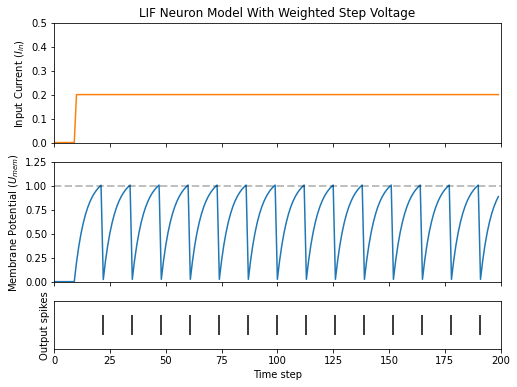

In [11]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = jnp.concatenate([jnp.zeros(10), jnp.ones(190)*0.5])
mem = jnp.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = lif(mem, x[step]*w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = jnp.stack(mem_rec)
spk_rec = jnp.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

## Simulating a Spiking Feed Forward Network
We're now ready to put these together in to a simple network. This is thankfully a much simpler job for us since we don't need to worry about making it differentiable.
https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_3.html

In [12]:
hidden_sizes = [28*28, 1000, 10]

In [13]:
def init(hidden_sizes):
  """ Create network initial weights and the initial state of the membrain
  potentials.
  """
  ws = []
  mem = []
  key = jax.random.PRNGKey(0)
  for i in range(len(hidden_sizes) - 1):
    rnd, key = jax.random.split(key)
    ws.append(jax.random.normal(rnd, (hidden_sizes[i], hidden_sizes[i+1]))*0.1)
    mem.append(jnp.zeros(hidden_sizes[i+1]))
  return ws, mem

In [14]:
# Super simple linear layer, SNNs don't use bias.
def linear(x, w):
  return jnp.dot(x, w)

In [15]:
# This represents one step of the simulation of the spikes running though the
# network. We need to simulate hundreds steps just to get a single output and
# most of this computation involves zeros. This is why SNNs are not efficient
# on hardware designed for ANNs. 
def model(key, x, ws, mems, beta=0.95):
  spk = rate_code(key, x)
  new_mem = []
  new_spk = [spk]
  for w, mem in zip(ws, mems):
    spk = linear(spk, w)
    spk, mem = lif(mem, spk, beta=beta)
    new_mem.append(mem)
    new_spk.append(spk)

  return new_spk, new_mem

In [16]:
%%time
ws, mem = init(hidden_sizes)
all_spk = []
all_mem = []
# Run the simulation for a few time steps and record the spiking activity
for _ in range(num_steps):
  rnd, key = jax.random.split(key)
  spk, mem = model(key, digit.flatten(), ws, mem)
  all_spk.append(spk)
  all_mem.append(mem)

CPU times: user 5.68 s, sys: 4.48 s, total: 10.2 s
Wall time: 10.6 s


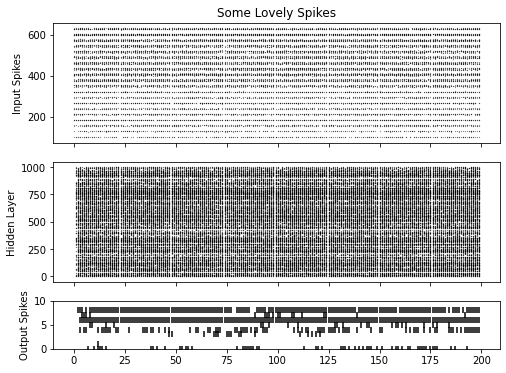

In [17]:
all_spk = [jnp.stack(s) for s in zip(*all_spk)]
plot_snn_spikes(all_spk[0], all_spk[1], all_spk[2], 'Some Lovely Spikes')

In [18]:
# Now let's use jax.scan and jitting to make the simulation much faster
ws, mem = init(hidden_sizes)

@jax.jit
def run_sim(key, x, ws, mem):
  def step(carry, _):
    key, mem = carry
    rnd, key = jax.random.split(key)
    spk, mem = model(rnd, x, ws, mem)
    return (key, mem), (spk, mem)
  _, (spk, mem) = jax.lax.scan(step, (key, mem), None, length=num_steps)
  return spk, mem

In [19]:
#warm it up!!
key = jax.random.PRNGKey(0)
ws, mem = init(hidden_sizes)
run_sim(key, digit.flatten(), ws, mem);

In [20]:
%%time
ws, mem = init(hidden_sizes)
spk, mem = run_sim(key, digit.flatten(), ws, mem)

CPU times: user 33.9 ms, sys: 18.5 ms, total: 52.4 ms
Wall time: 60.7 ms


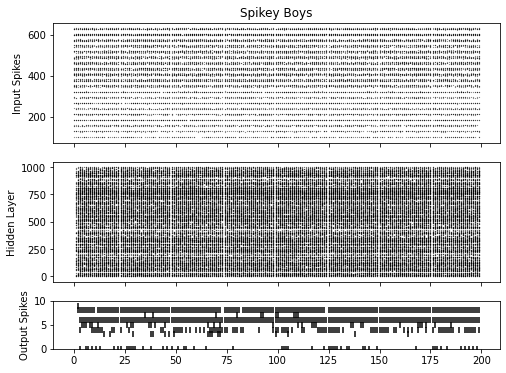

In [21]:
plot_snn_spikes(spk[0], spk[1], spk[2], 'Spikey Boys')

In [22]:
# We can also visualise the membrane potentials
media.show_image(mem[1].T, width=num_steps*4, cmap='hot')

""


## Build SNN Policy
Time to build an EvoJAX policy so that we can train it!

In [23]:
from typing import Sequence, Tuple

from flax import linen as nn

from evojax.policy.base import PolicyNetwork
from evojax.policy.base import PolicyState
from evojax.task.base import TaskState

from evojax.util import get_params_format_fn


class SNNPolicy(PolicyNetwork):

    def __init__(self,
                 input_dim: int,
                 hidden_dims: Sequence[int],
                 output_dim: int,
                 time_steps: int):

      params, init_mem = init([input_dim] + hidden_dims + [output_dim])

      def run_sim(key, x, ws, mem):
        def step(carry, _):
          key, mem = carry
          rnd, key = jax.random.split(key)
          spk, mem = model(rnd, x, ws, mem)
          return (key, mem), spk[-1]

        # NOTE: This version of run_sim only records the final layers's spikes
        # to save on memory. Don't need all the other stuff if we are not 
        # visualising them.
        _, spk = jax.lax.scan(step, (key, mem), None, length=time_steps)
        return spk

      def apply(params, x, p_states):
        x = x.flatten()
        keys, rnd = jax.random.split(p_states.keys)

        spk = run_sim(rnd, x, params, init_mem)

        # The tutorial use the final layer's membrane potentials as outputs
        # but let's be more pure and use the sum of all the spikes.
        x = spk.mean(axis=0)
        x = nn.log_softmax(x)
        return x, PolicyState(keys=keys)

      # Careful! In other examples we use flax to build the neural network
      # based policies which automatically build neural networks that expects
      # a batch of inputs. Here the other hand, `apply` was built for one input
      # only, so we have to allow the function to process batches by using vmap.
      # But we only want to batch the inputs and outputs of the network so we 
      # have to make careful use of in_axes and out_axes parameters.
      # The function is then passed though vmap again below to allow it to
      # process multiple batches at the same time to evaluate individuals in
      # the population in parallel.
      apply = jax.vmap(apply, in_axes=(None, 0, None), out_axes=(0, None))

      self.num_params, format_params_fn = get_params_format_fn(params)
      self._format_params_fn = jax.vmap(format_params_fn)
      self._forward_fn = jax.vmap(apply)

    def get_actions(self,
                    t_states: TaskState,
                    params: jnp.ndarray,
                 
                    p_states: PolicyState) -> Tuple[jnp.ndarray, PolicyState]:
        params = self._format_params_fn(params)
        return self._forward_fn(params, t_states.obs, p_states)

    def reset(self, states: TaskState) -> PolicyState:
      dims = states.obs.shape[0]

      return PolicyState(
          # Use same random seed so that the inputs spikes are the same!
          keys=jnp.tile(jax.random.PRNGKey(12345)[None,:], (dims,1,)),
      )

# Training

In [24]:
# @title Set hyper-parameters
# @markdown PLEASE NOTE: `pop_size` and `num_tests` should be multiples of `jax.local_device_count()`.

n_devices = jax.local_device_count()

pop_size = 128  # @param
assert pop_size % n_devices == 0

time_steps = 50  # @param
batch_size = 256  # @param
max_iters = 1000  # @param
center_lr = 0.006  # @param
init_std = 0.04  # @param
std_lr = 0.09  # @param

seed = 42  # @param

In [25]:
from evojax import SimManager
from evojax.algo import PGPE

train_task = MNIST(batch_size=batch_size, test=False)
test_task = MNIST(batch_size=batch_size, test=True)

policy = SNNPolicy(
    input_dim=28*28,
    hidden_dims=[1000],
    output_dim=10,
    time_steps=time_steps)

num_tests=1

solver = PGPE(
    pop_size=pop_size,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=center_lr,
    stdev_learning_rate=std_lr,
    init_stdev=init_std,
    seed=seed,
)

sim_mgr = SimManager(
    n_repeats=1,
    test_n_repeats=1,
    pop_size=pop_size,
    n_evaluations=num_tests,
    policy_net=policy,
    train_vec_task=train_task,
    valid_vec_task=test_task,
    seed=seed,
)

In [26]:
import time
import numpy as np

start_time = time.perf_counter()
for train_iters in range(max_iters):
  
  # Training.
  params = solver.ask()
  scores, _ = sim_mgr.eval_params(params=params, test=False)
  solver.tell(fitness=scores)

  # Test periodically.
  if train_iters > 0 and train_iters % 10 == 0:
      best_params = solver.best_params
      scores = np.array(sim_mgr.eval_params(params=best_params, test=True)[0])
      score_best = scores.max()
      score_avg = np.mean(scores)
      print('Iter={0}, #tests={1}, score.best={2:.3f}, score.avg={3:.3f}'.format(
          train_iters, num_tests, score_best, score_avg))

# Final test.
best_params = solver.best_params
scores = np.array(sim_mgr.eval_params(params=best_params, test=True)[0])
score_best = scores.max()
score_avg = np.mean(scores)
print('Iter={0}, #tests={1}, score.best={2:.3f}, score.avg={3:.3f}'.format(
    train_iters, num_tests, score_best, score_avg))
print('time cost: {}s'.format(time.perf_counter() - start_time))

/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/_src/dispatch.py:271: UserWarning: The jitted function <unnamed function> includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  f"The jitted function {name} includes a pmap. Using "


Iter=10, #tests=1, score.best=0.277, score.avg=0.277
Iter=20, #tests=1, score.best=0.505, score.avg=0.505
Iter=30, #tests=1, score.best=0.645, score.avg=0.645
Iter=40, #tests=1, score.best=0.717, score.avg=0.717
Iter=50, #tests=1, score.best=0.741, score.avg=0.741
Iter=60, #tests=1, score.best=0.765, score.avg=0.765
Iter=70, #tests=1, score.best=0.778, score.avg=0.778
Iter=80, #tests=1, score.best=0.790, score.avg=0.790
Iter=90, #tests=1, score.best=0.796, score.avg=0.796
Iter=100, #tests=1, score.best=0.806, score.avg=0.806
Iter=110, #tests=1, score.best=0.818, score.avg=0.818
Iter=120, #tests=1, score.best=0.820, score.avg=0.820
Iter=130, #tests=1, score.best=0.825, score.avg=0.825
Iter=140, #tests=1, score.best=0.832, score.avg=0.832
Iter=150, #tests=1, score.best=0.838, score.avg=0.838
Iter=160, #tests=1, score.best=0.842, score.avg=0.842
Iter=170, #tests=1, score.best=0.842, score.avg=0.842
Iter=180, #tests=1, score.best=0.843, score.avg=0.843
Iter=190, #tests=1, score.best=0.843,

## Final Analysis
Let's look at a few example test set inputs in the trained network.

In [27]:
@jax.jit
def run_sim(key, x, ws, mem):
  def step(carry, _):
    key, mem = carry
    rnd, key = jax.random.split(key)
    spk, mem = model(rnd, x, ws, mem)
    return (key, mem), (spk, mem)
  _, (spk, mem) = jax.lax.scan(step, (key, mem), None, length=time_steps)
  return spk, mem

In [28]:
# _format_params_fn is vmapped so expects a batch dimension, so we need to add
# an extra dimension at the start and then squeeze the results to get rid of the
# batch dimension again.
params = [jnp.squeeze(w) for w in policy._format_params_fn(best_params[None, :])]

/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


In [29]:
data = test_task.reset(key=jax.random.split(jax.random.PRNGKey(42)))

""


Label: 7
Pred:  7
*** Correct :D ***


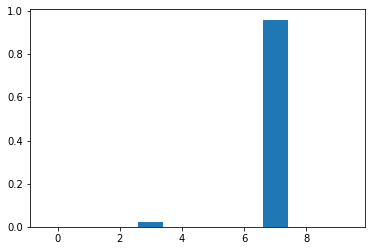

""


Label: 2
Pred:  2
*** Correct :D ***


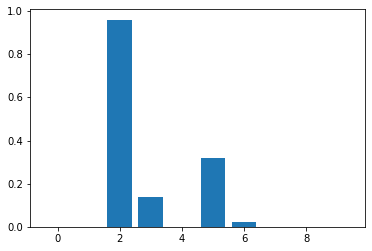

""


Label: 1
Pred:  1
*** Correct :D ***


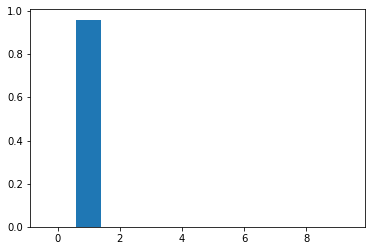

""


Label: 0
Pred:  0
*** Correct :D ***


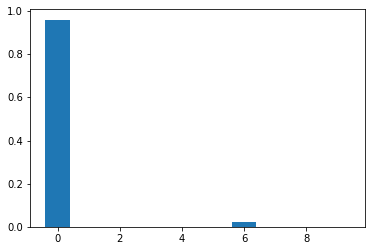

""


Label: 4
Pred:  4
*** Correct :D ***


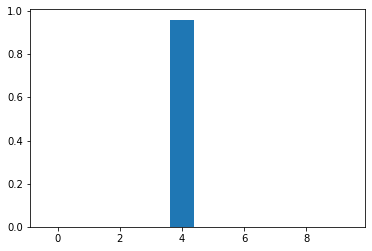

""


Label: 1
Pred:  1
*** Correct :D ***


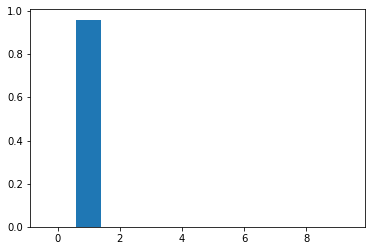

""


Label: 4
Pred:  4
*** Correct :D ***


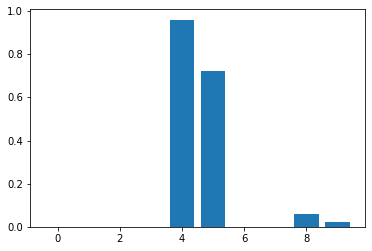

""


Label: 9
Pred:  9
*** Correct :D ***


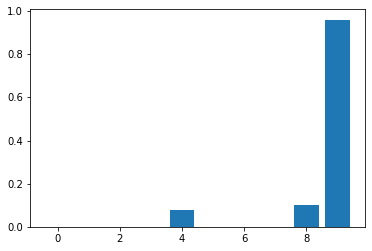

""


Label: 5
Pred:  6
*** Wrong :( ***


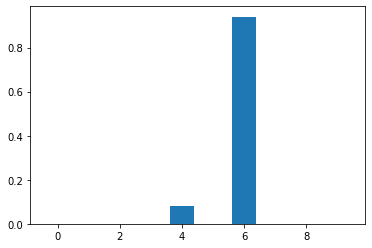

""


Label: 9
Pred:  9
*** Correct :D ***


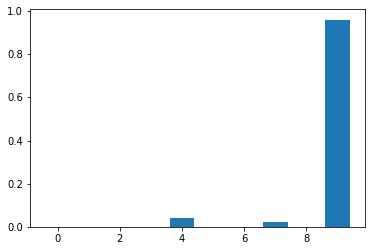

""


Label: 0
Pred:  0
*** Correct :D ***


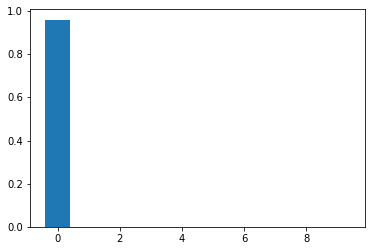

""


Label: 6
Pred:  6
*** Correct :D ***


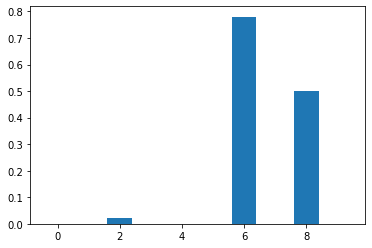

""


Label: 9
Pred:  9
*** Correct :D ***


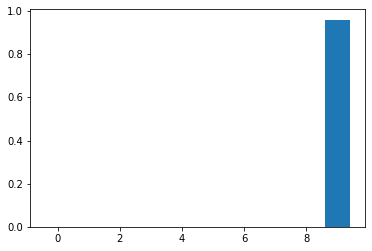

""


Label: 0
Pred:  0
*** Correct :D ***


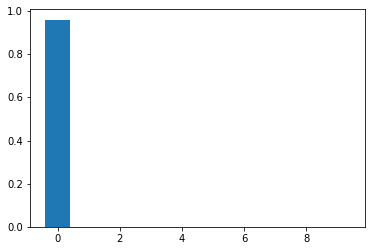

""


Label: 1
Pred:  1
*** Correct :D ***


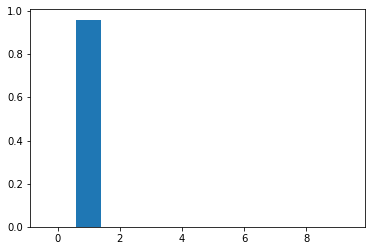

""


Label: 5
Pred:  5
*** Correct :D ***


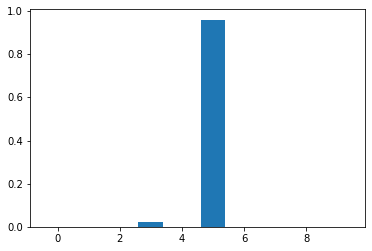

""


Label: 9
Pred:  9
*** Correct :D ***


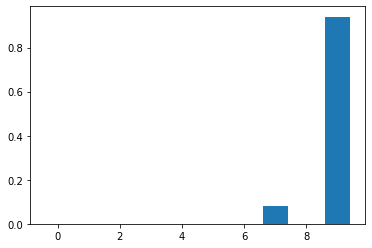

""


Label: 7
Pred:  7
*** Correct :D ***


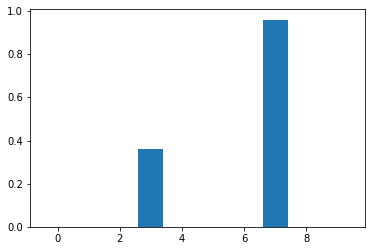

""


Label: 3
Pred:  3
*** Correct :D ***


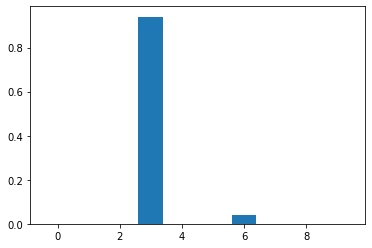

""


Label: 4
Pred:  4
*** Correct :D ***


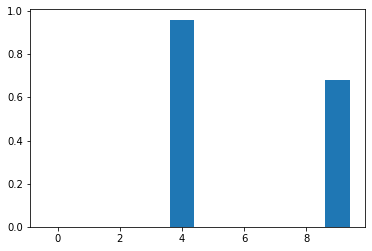

In [30]:
_, init_mem = init([28*28, 1000, 10])
for i in range(20):
  digit = data.obs[0][i]
  label = data.labels[0][i]
  media.show_image(jnp.reshape(digit, (28, 28)), height=28*8)

  spk, mem = run_sim(jax.random.PRNGKey(seed=42), digit.flatten(), params, init_mem)

  pred = spk[2].mean(axis=0).argmax()
  print('Label:', label)
  print('Pred: ', pred)
  if pred == label:
    print('*** Correct :D ***')
  else:
    print('*** Wrong :( ***')
  plt.bar(jnp.arange(10), spk[2].mean(axis=0))
  plt.show()

  print('='*50)

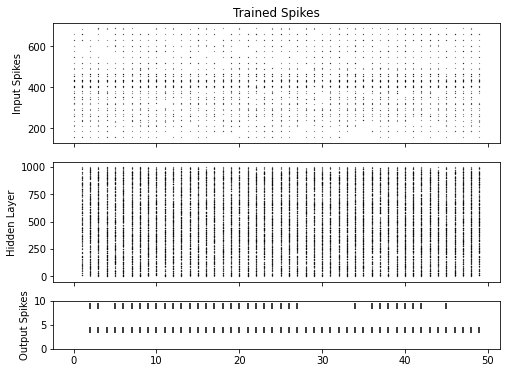

In [31]:
plot_snn_spikes(spk[0], spk[1], spk[2], 'Trained Spikes')

In [32]:
# Interestingly, visualising the weights doesn't show any obvious structure...
media.show_images(jnp.reshape(params[0][:, :10], (28, 28, -1)).transpose((2, 0, 1)), height=28*4, cmap='RdBu')

,,,,,,,,,
